<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

In [74]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import glob, os
import duckietown_code_utils as dcu
import random
import cv2

%matplotlib inline
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Implementation of Braitenberg agent

Now we know enough about image filtering to implement our Braitenberg agent such that it will avoid duckies.<br>
You already updated the image preprocessing in the last activity to highlight duckies.<br> 
Now it's time to handle the sensorimotor connections in order to control our agent.

### Setup

We will implement an agent of the form

```python
left_motor  = const + gain *  np.sum( LEFT * preprocess(image) )
right_motor = const + gain *  np.sum( RIGHT * preprocess(image) )
```

where `LEFT` and `RIGHT` are the weight matrices, while `const` and `gain` are two extra parameters for fine tuning.

To do this you will have to implement the two functions `get_motor_left_matrix()` and `get_motor_right_matrix()` in the file [connections.py](../../packages/solution/connections.py). <br>
The file contains code that creates connections but currently uses random values. <br>
You will erase these and use your own.

The other important code, which you need to **not** touch (for now), is the file [agent.py](../../packages/braitenberg_agent/agent.py). <br>
This contains the rest of the Braitenberg agent, including all of the functionality (reading observations and creating motor commands). <br>
The agent will load the `get_motor_left_matrix`, `get_motor_right_matrix` functions from the file [connections.py](../../packages/solution/connections.py).

### Visualization
Before you jump into editing the code, we can also load the functions from `connections.py` into this notebook to visualize their output:

In [75]:
from solution.connections import get_motor_left_matrix, get_motor_right_matrix

Let's visualize what the functions above are doing. As we said, the defaults do not make much sense, so not we won't see anything interesting. But as you go and change the functions, then you will see more interesting results. You can come back to this notebook as you fine-tune your solution to see the updates. We'll start with the duckie image once again.

**Note: you might need to reload the kernel for the notebook to detect the changes you make.**

In [76]:
fn = '../../assets/samples/big-duck/big-duck-10.jpg'
image1 = dcu.rgb_from_jpg_fn(fn);
image1_gray = np.mean(image1, axis=2)
shape = image1_gray.shape
print(shape)

(480, 640)


The `shape` that was just printed above will be useful to you when you edit [connections.py](../../packages/solution/connections.py) as well as the visualizations of the motor matrices below.

In [77]:
L = get_motor_left_matrix(shape)
R = get_motor_right_matrix(shape)

Found 1 images.
Image: ../../assets/samples/duckies_simulation/duckie_sim_01.jpg


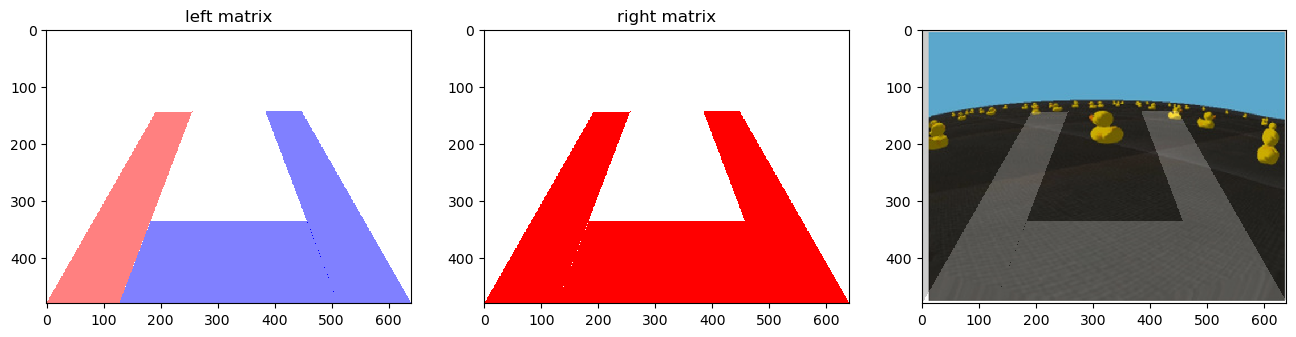

In [129]:
# Visualizing left and right matrices
# The colors red and blue represent 
# normalized positive and negative values, respectively

dirname = '../../assets/samples/duckies_simulation'
images = glob.glob(f'{dirname}/*.jpg')
print(f"Found {len(images)} images.")
im = random.choice(images, 1)[0]
print(f"Image: {im}")
im = dcu.rgb_from_jpg_fn(im)
I =  Image.fromarray(im.astype('uint8'), 'RGB').convert('RGBA').resize((640,480))
mask = R.astype(int).copy()
mask[mask != 0] = 1
M =  Image.fromarray(np.uint8(mask*255)).convert('RGBA')
B = Image.blend(I, M, alpha=.2)

f = plt.figure(figsize=(16,8))
f.add_subplot(1, 3, 1)
plt.imshow(dcu.posneg(L))
plt.title('left matrix');
f.add_subplot(1, 3, 2)
plt.imshow(dcu.posneg(R))
plt.title('right matrix');
f.add_subplot(1, 3, 3)
plt.imshow(B)



The following code will run the algorithm against some test images.

Note that it is not possible to really test such an algorithm on passive data. We need to run it!

Still, it is useful to see how your matrices are used. We simply multiply them with the preprocessed image
(the image that now only has non-zero pixel values where there are duckies). <br>
Then, we look at the sign of the result for each matrix, and this is what decides which control values get sent to the motors.<br>

Think about how to value your matrices such that the sign of their multiplication's results is a good control rule for your motors.

DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.8/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.8/dist-packages pyparsing 2.4.6


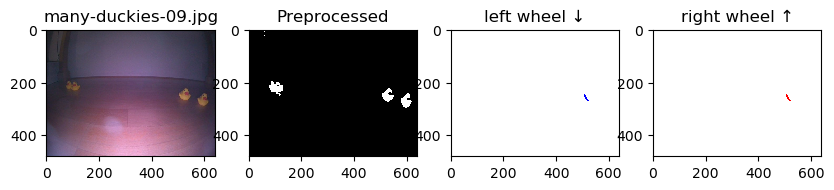

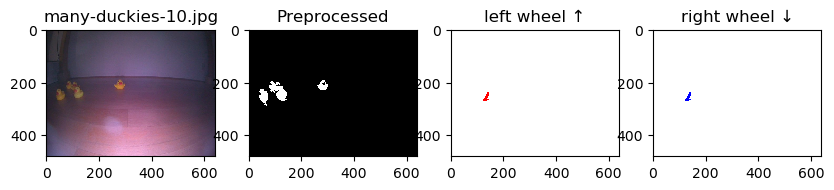

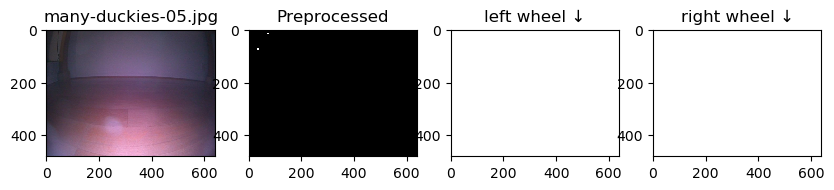

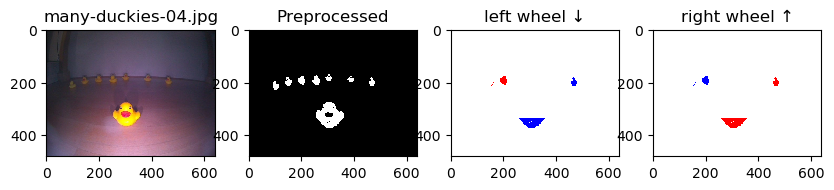

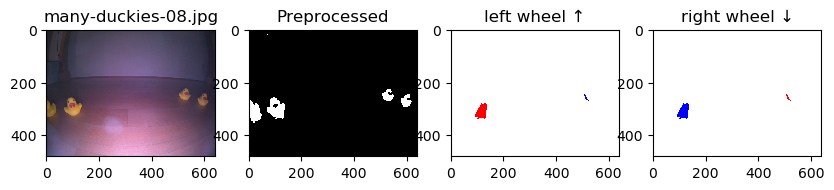

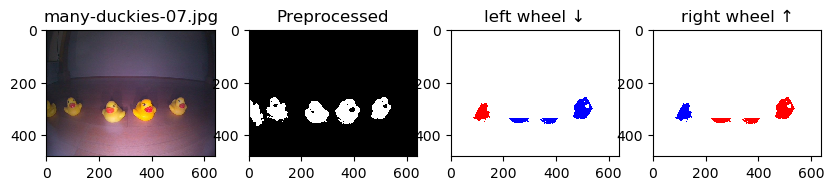

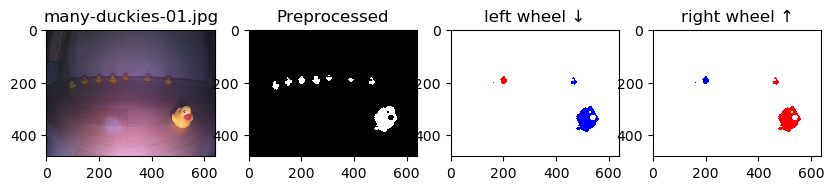

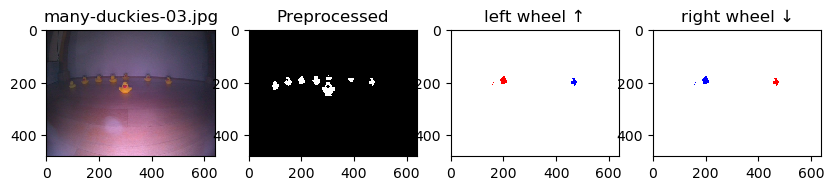

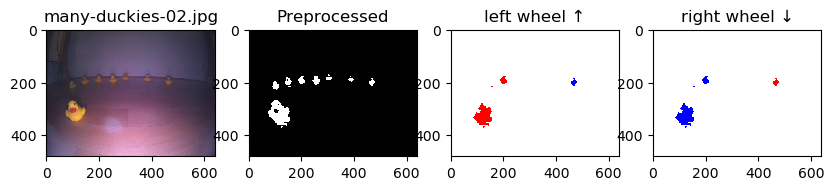

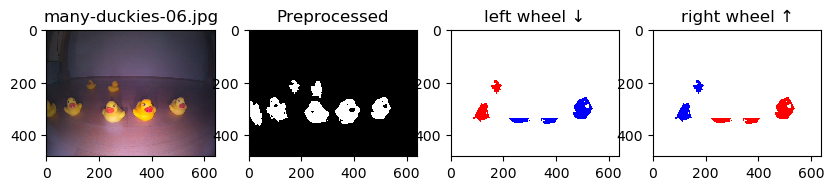

In [7]:
from matplotlib import pylab
import glob, os

from braitenberg_agent.agent import preprocess

dirname = '../../assets/samples/many-duckies'
images = glob.glob(f'{dirname}/*.jpg')

for a in images:
    im = dcu.rgb_from_jpg_fn(a)
    P = preprocess(im)
    Lim = P * L
    Rim = P * R
    Lsign = np.sum(Lim)
    Rsign = np.sum(Rim)
    f = pylab.figure(figsize=(10,2))
    f.add_subplot(1, 4, 1)
    plt.imshow(im)
    pylab.title(os.path.basename(a))
    f.add_subplot(1, 4, 2)
    plt.imshow(P, cmap='gray')
    pylab.title("Preprocessed")
    f.add_subplot(1, 4, 3)
    plt.imshow(dcu.posneg(Lim))
    pylab.title('left wheel ' + ('↑' if Lsign > 0 else '↓'))
    f.add_subplot(1, 4, 4)
    plt.imshow(dcu.posneg(Rim), cmap='bwr')
    pylab.title('right wheel ' + ('↑' if Rsign > 0 else '↓'))


### Build your agent
Now that the visualizations are set up, you can edit `connections.py` and test your agent according to the instructions in the [README](../../README.md).

Use the `workbench` command (also described in the README) to check on your agent's performance as you update the functions. <br>
To test in simulation, you will first build the exercise using

`dts code build`

Followed by

`dts code workbench --sim`

which will give you a link to the running simulation (you may have to scroll up in your terminal to find the `Sim running at: <URL>` output). There you will be able to see your agent commanding the Duckiebot through a field of Duckies. See if you can make it across without hitting any!

Consider the agent that we gave you as a starting point - feel free to explore with using different code in [agent.py](../../packages/braitenberg_agent/agent.py). <br>
You may need to tune the `gain` and `const` values in the `BraitenbergAgentConfig` class to fit your agent and Duckiebot. <br>
Pay attention to use a combination of `gain` and `const` values in such a way that the motor inputs fall within the range of -1 to 1, otherwise you may encounter a `ValueError`.

### Submitting this exercise
Remember that to hand in this exercise, you will have to complete the final step in the README instructions successfully (`dts code submit`).  Be sure to use the URL that is generated to follow your agent's progress and compare it to other submitted solutions!
